# Analysis of data using `rcpy`

## Loading data

In [1]:
import matplotlib.pyplot as plt
from rcpy.data import ClimateIndex, load_NOAA_data

data = load_NOAA_data(ClimateIndex.NINO1870)
series = data['index'][:-12]

Reading NOAA data for Nino3.4 HadISST (1870-2025)
Start Year: 1870, End Year: 2025
Number of years: 156


## Preliminary Data analysis

Global mean = -0.098
Global variance = 0.600
Skewness = 0.474
Kurtosis = 0.382


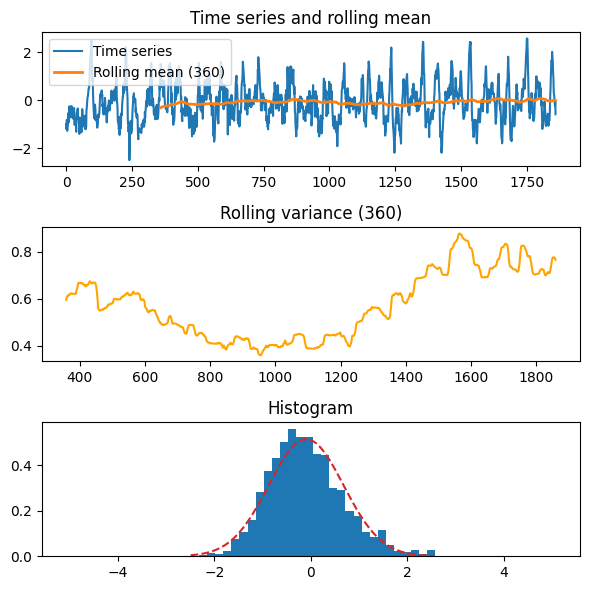

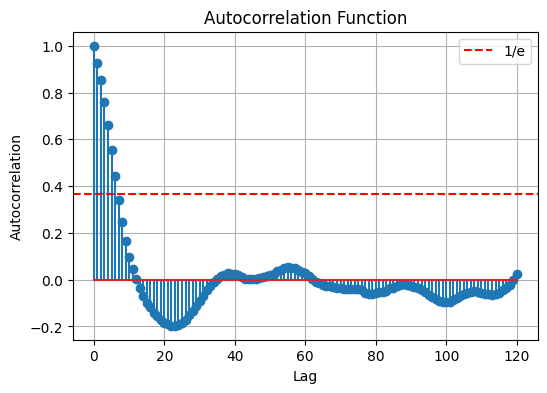

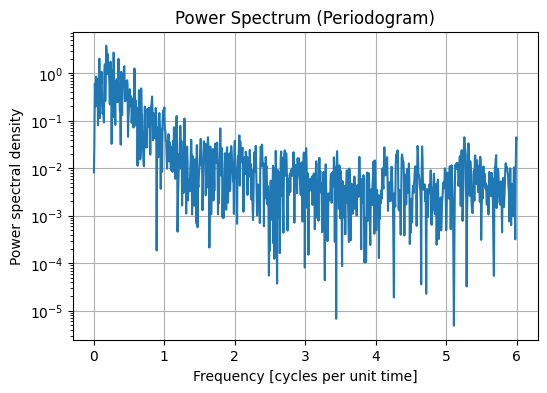

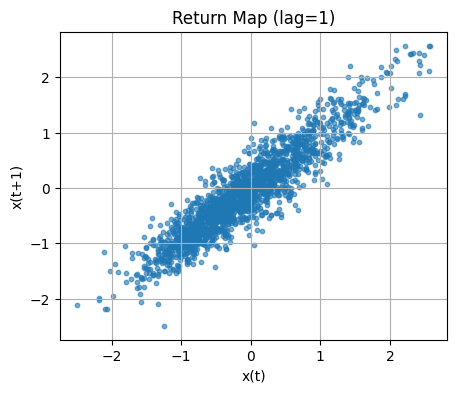

In [14]:
from rcpy.data import analyze_basic_stats, plot_autocorrelation, plot_power_spectrum, plot_return_map

stats_summary = analyze_basic_stats(series, window=360, plot=True)
acf = plot_autocorrelation(series, max_lag=120, scale=None)
f, Pxx = plot_power_spectrum(series, fs=12, scale=None)
plot_return_map(series, lag=1)

## Autocorrelation matrix

(48, 24)


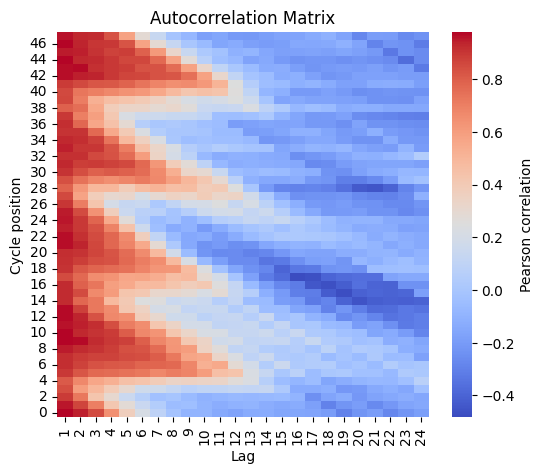

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from rcpy.data import autocorr_matrix

cycle_length = 48  # e.g., quarterly data over 12 years
max_lag = 24
corr = autocorr_matrix(series, cycle_length=cycle_length, max_lag=max_lag)

print(corr.shape)  # (12, 12)


plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=False, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Pearson correlation'},
            xticklabels=[f"{i}" for i in range(1, max_lag + 1)])
plt.gca().invert_yaxis()
plt.xlabel("Lag")
plt.ylabel("Cycle position")
plt.title("Autocorrelation Matrix")
plt.show()

## Memory length

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg

# ==========================================================
# s = your 1D numpy array, e.g.
# s = np.loadtxt('nino34_values.txt')
# ==========================================================

def deseasonalize_array(arr):
    """Remove mean seasonal cycle (12-month period) from a 1D array."""
    arr = np.asarray(arr).flatten()
    N = len(arr)
    months = np.arange(N) % 12  # assign month indices 0..11
    monthly_means = np.array([arr[months == m].mean() for m in range(12)])
    deseason = arr - monthly_means[months]
    return deseason

def compute_acf_pacf(arr, nlags=120):
    arr = np.asarray(arr)
    ac = acf(arr, nlags=nlags, fft=True)
    # use 'yw' (Yule-Walker) instead of deprecated 'ywunbiased'
    pc = pacf(arr, nlags=nlags, method='yw')
    return ac, pc

def integrated_autocorr_time(acf_vals):
    rho = acf_vals
    neg_idx = np.where(rho[1:] <= 0)[0]
    if len(neg_idx) > 0:
        K = neg_idx[0] + 1
    else:
        K = len(rho) - 1
    tau = 1 + 2 * np.sum(rho[1:K+1])
    return tau, K

def fit_ar(arr, lags=12):
    model = AutoReg(arr, lags=lags, old_names=False).fit()
    return model

def generate_ar_sim(model, n_steps, burn=100):
    return model.simulate(n_steps + burn)[burn:]

def hurst_rs(arr):
    """Estimate Hurst exponent via R/S method."""
    X = np.asarray(arr).flatten()
    N = len(X)
    T = np.arange(1, N + 1)
    Y = np.cumsum(X - X.mean())
    R = np.maximum.accumulate(Y) - np.minimum.accumulate(Y)
    S = np.array([X[:k].std(ddof=1) for k in range(1, N + 1)])
    with np.errstate(divide='ignore', invalid='ignore'):
        RS = R / S
    valid = np.isfinite(RS) & (RS > 0)
    T = T[valid]
    RS = RS[valid]
    if len(RS) < 20:
        return np.nan
    x = np.log(T)
    y = np.log(RS)
    H = np.polyfit(x, y, 1)[0]
    return H


In [ ]:
# ==========================================================
# Memory length
# ==========================================================

# Suppose s is your numpy array:
# s = np.loadtxt('nino34_values.txt')

# 1. Deseasonalize
s = series
s_ds = deseasonalize_array(s)

# 2. Compute ACF/PACF
ac, pc = compute_acf_pacf(s_ds, nlags=120)

# 3. Integrated autocorrelation time
tau, K = integrated_autocorr_time(ac)
print('Integrated autocorrelation time (months):', tau)
print('Truncation lag K:', K)

# 4. Fit AR model
model = fit_ar(s_ds, lags=24)
print(model.summary())

# 5. Compute Hurst exponent
H = hurst_rs(s_ds)
print('Hurst exponent (R/S):', H)

Integrated autocorrelation time (months): 11.193659913690034
Truncation lag K: 12
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1860
Model:                    AutoReg(24)   Log Likelihood                -266.196
Method:               Conditional MLE   S.D. of innovations              0.280
Date:                Sat, 18 Oct 2025   AIC                            584.393
Time:                        14:22:13   BIC                            727.792
Sample:                            24   HQIC                           637.274
                                 1860                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.007      0.098      0.922      -0.012       0.013
y.L1           0.9296      0.023     39.816      

/home/user/miniforge3/envs/krc/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/miniforge3/envs/krc/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
